# Import Library

In [12]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.utils import to_categorical

In [2]:
DATASET_PATH = "data/train/"

# Feature Extraction

In [3]:
def extract_features(file_path, max_pad_length=100):
    y, sr = librosa.load(file_path, sr=16000)  # Load with 16kHz sample rate
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Padding or truncating
    pad_width = max_pad_length - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_length]
    
    return mfcc

In [4]:
X, y = [], []

for dialect in os.listdir(DATASET_PATH):  
    dialect_path = os.path.join(DATASET_PATH, dialect)
    for speaker in os.listdir(dialect_path):
        speaker_path = os.path.join(dialect_path, speaker)
        
        label = 0 if speaker[0] == 'M' else 1  # 'M' for Male, 'F' for Female

        for file in os.listdir(speaker_path):
            if file.endswith(".WAV"):
                file_path = os.path.join(speaker_path, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label)

X = np.array(X)
y = np.array(y)

In [5]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Add channel dimension

In [6]:
y = to_categorical(y, num_classes=2)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

C:\Users\HP\AppData\Local\Temp\ipykernel_14380\4282749212.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Male', 'Female'], y=gender_counts, palette=['blue', 'red'])


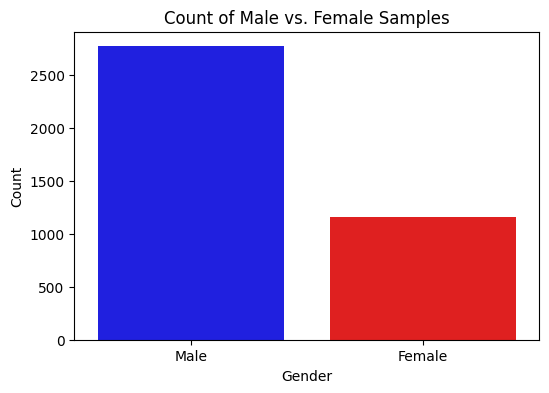

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert one-hot encoded labels to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Count occurrences of each gender
gender_counts = np.bincount(y_train_labels)

# Create bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['Male', 'Female'], y=gender_counts, palette=['blue', 'red'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Count of Male vs. Female Samples")
plt.show()

In [9]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train.argmax(axis=1))

# Reshape back
X_train_resampled = X_train_resampled.reshape(-1, 13, 100, 1)
y_train_resampled = to_categorical(y_train_resampled, num_classes=2)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape

model = Sequential([
    # CNN Feature Extraction
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(13, 100, 1)),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),

    Flatten(),  # Converts CNN output into a 1D vector

    # Dynamically compute a valid reshape dimension
    Reshape((16, 6400 // 16)),  # Ensures total elements remain 6400

    # LSTM Layer
    LSTM(128, return_sequences=False),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 13, 100, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 7, 50, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 7, 50, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 50, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 25, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 4, 25, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_10 (Reshape)                 │ (None, 16, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         270,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,434 (1.17 MB)

 Trainable params: 306,434 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7343 - loss: 0.4981 - val_accuracy: 0.8687 - val_loss: 0.3421
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8918 - loss: 0.2742 - val_accuracy: 0.9048 - val_loss: 0.2476
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9292 - loss: 0.1808 - val_accuracy: 0.9538 - val_loss: 0.1374
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9518 - loss: 0.1279 - val_accuracy: 0.9596 - val_loss: 0.1065
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9648 - loss: 0.0997 - val_accuracy: 0.9538 - val_loss: 0.1578
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9783 - loss: 0.0624 - val_accuracy: 0.9668 - val_loss: 0.0888
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9799 - loss: 0.0588 - val_accuracy: 0.9567 - val_loss: 0.1314
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9759 - loss: 0.0716 - val_accu

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9672 - loss: 0.1524
Test Accuracy: 0.9711, Test Loss: 0.1230


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 
              precision    recall  f1-score   support

        Male       0.98      0.98      0.98       489
      Female       0.96      0.95      0.95       204

    accuracy                           0.97       693
   macro avg       0.97      0.96      0.97       693
weighted avg       0.97      0.97      0.97       693



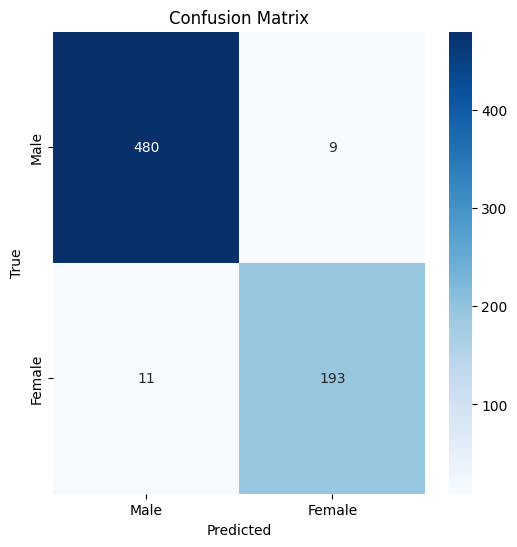

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=["Male", "Female"]))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

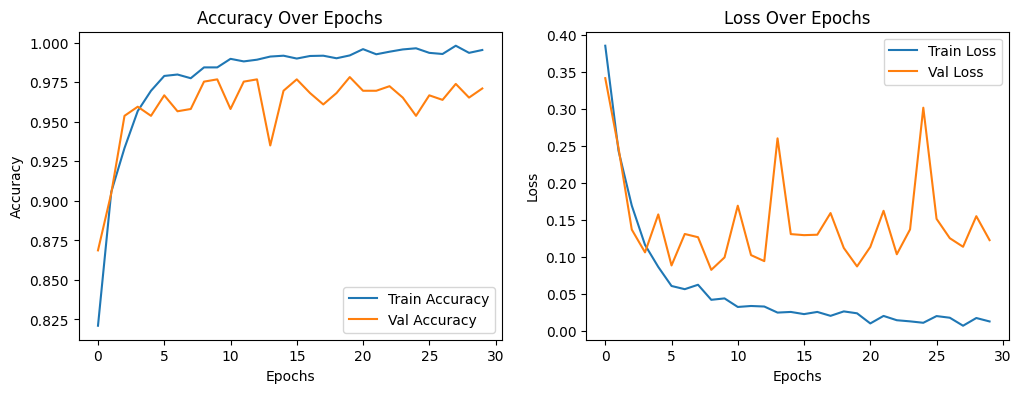

In [29]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

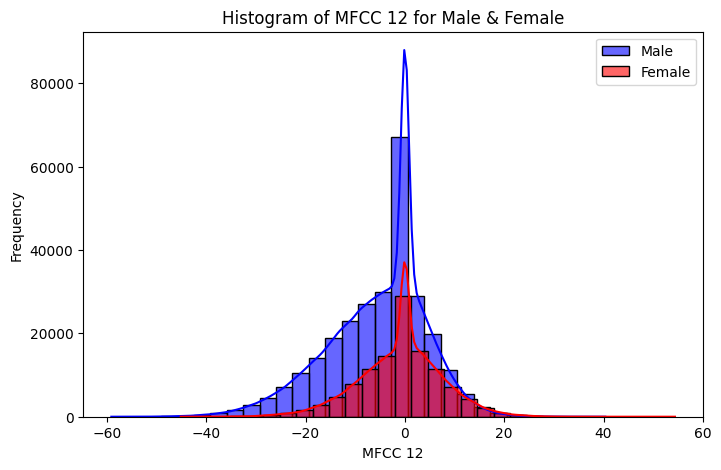

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract a single MFCC feature (e.g., first MFCC coefficient)
mfcc_index = 12  

# Flatten the arrays
male_mfcc = X_train[y_train[:, 0] == 1][:, mfcc_index, :].flatten()
female_mfcc = X_train[y_train[:, 1] == 1][:, mfcc_index, :].flatten()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(male_mfcc, bins=30, color='blue', alpha=0.6, label='Male', kde=True)
sns.histplot(female_mfcc, bins=30, color='red', alpha=0.6, label='Female', kde=True)

plt.xlabel(f'MFCC {mfcc_index}')
plt.ylabel('Frequency')
plt.title(f'Histogram of MFCC {mfcc_index} for Male & Female')
plt.legend()
plt.show()

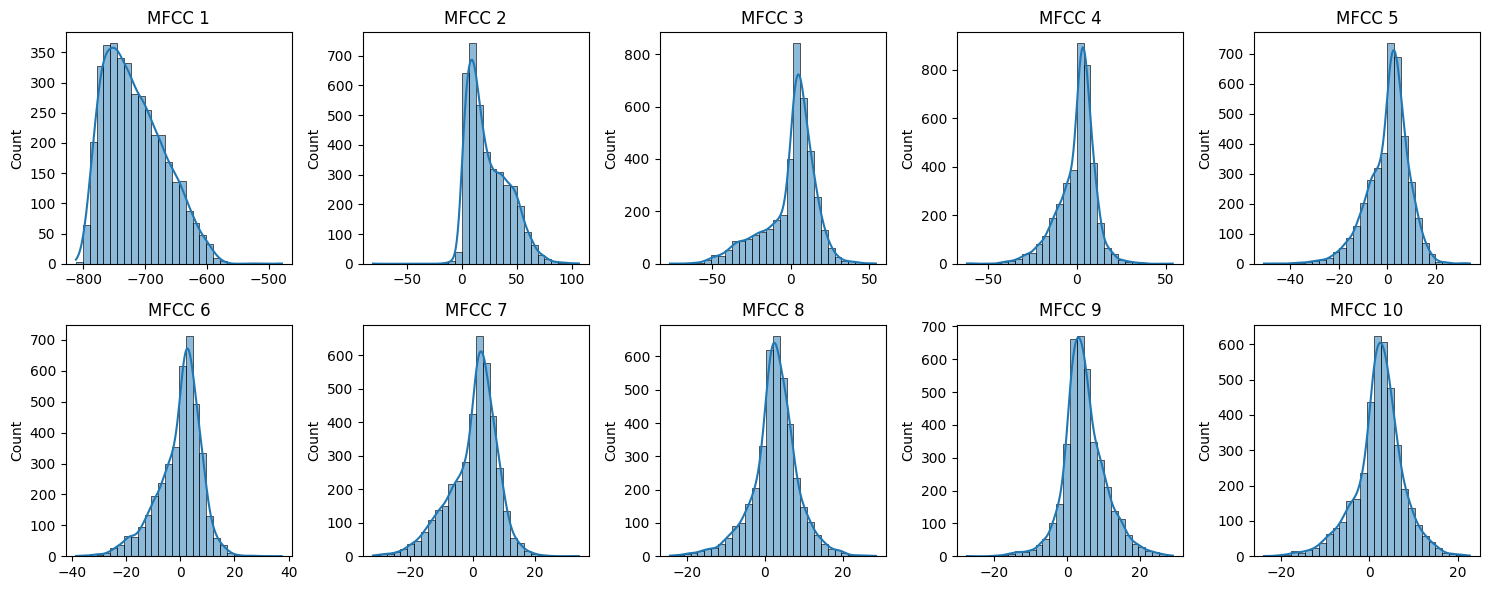

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_mfccs = 10  # Number of MFCCs to visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust layout

for i, ax in enumerate(axes.flatten()):
    if i < num_mfccs:
        sns.histplot(X_train[:, i, 0].flatten(), bins=30, ax=ax, kde=True)  # Flattened
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14380\1503745676.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Male', 'Female'], y=gender_counts, palette=['blue', 'red'])


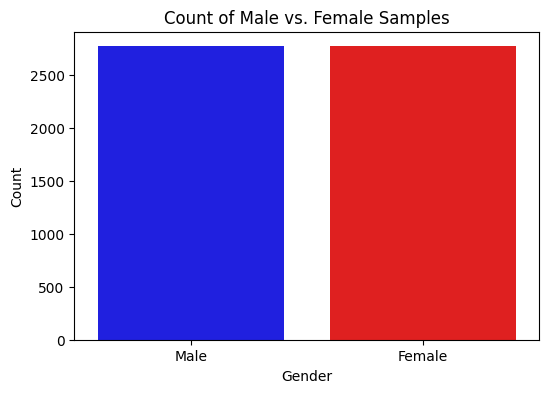

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert one-hot encoded labels to class labels
y_train_labels = np.argmax(y_train_resampled, axis=1)

# Count occurrences of each gender
gender_counts = np.bincount(y_train_labels)

# Create bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['Male', 'Female'], y=gender_counts, palette=['blue', 'red'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Count of Male vs. Female Samples")
plt.show()

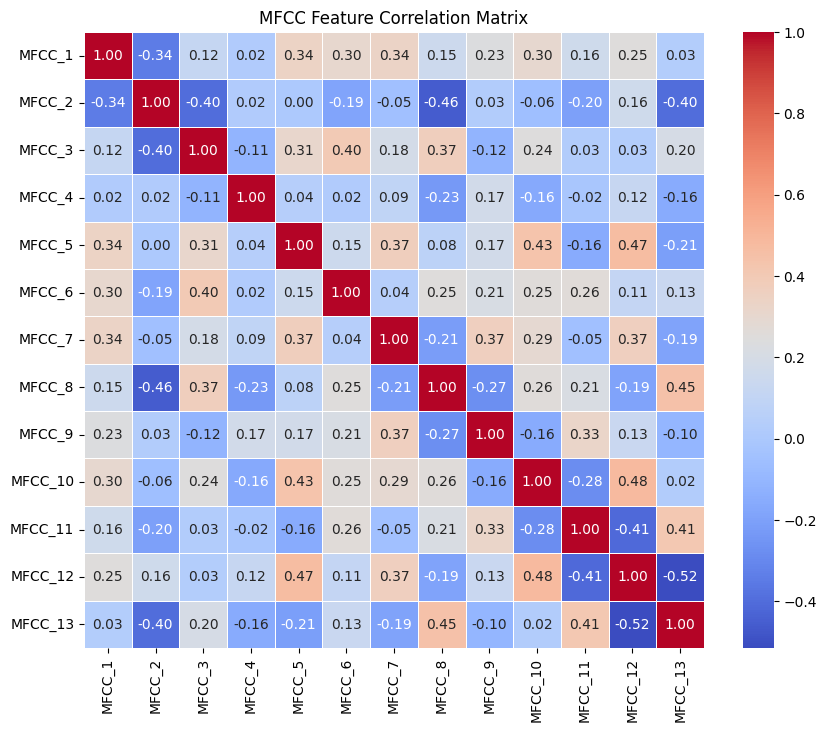

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean of MFCC features over time frames (axis=2) to get a 2D shape
mfcc_mean = X_train_resampled.mean(axis=2).squeeze()  # Shape: (5542, 13)

# Convert to DataFrame
df = pd.DataFrame(mfcc_mean, columns=[f'MFCC_{i+1}' for i in range(mfcc_mean.shape[1])])

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("MFCC Feature Correlation Matrix")
plt.show()

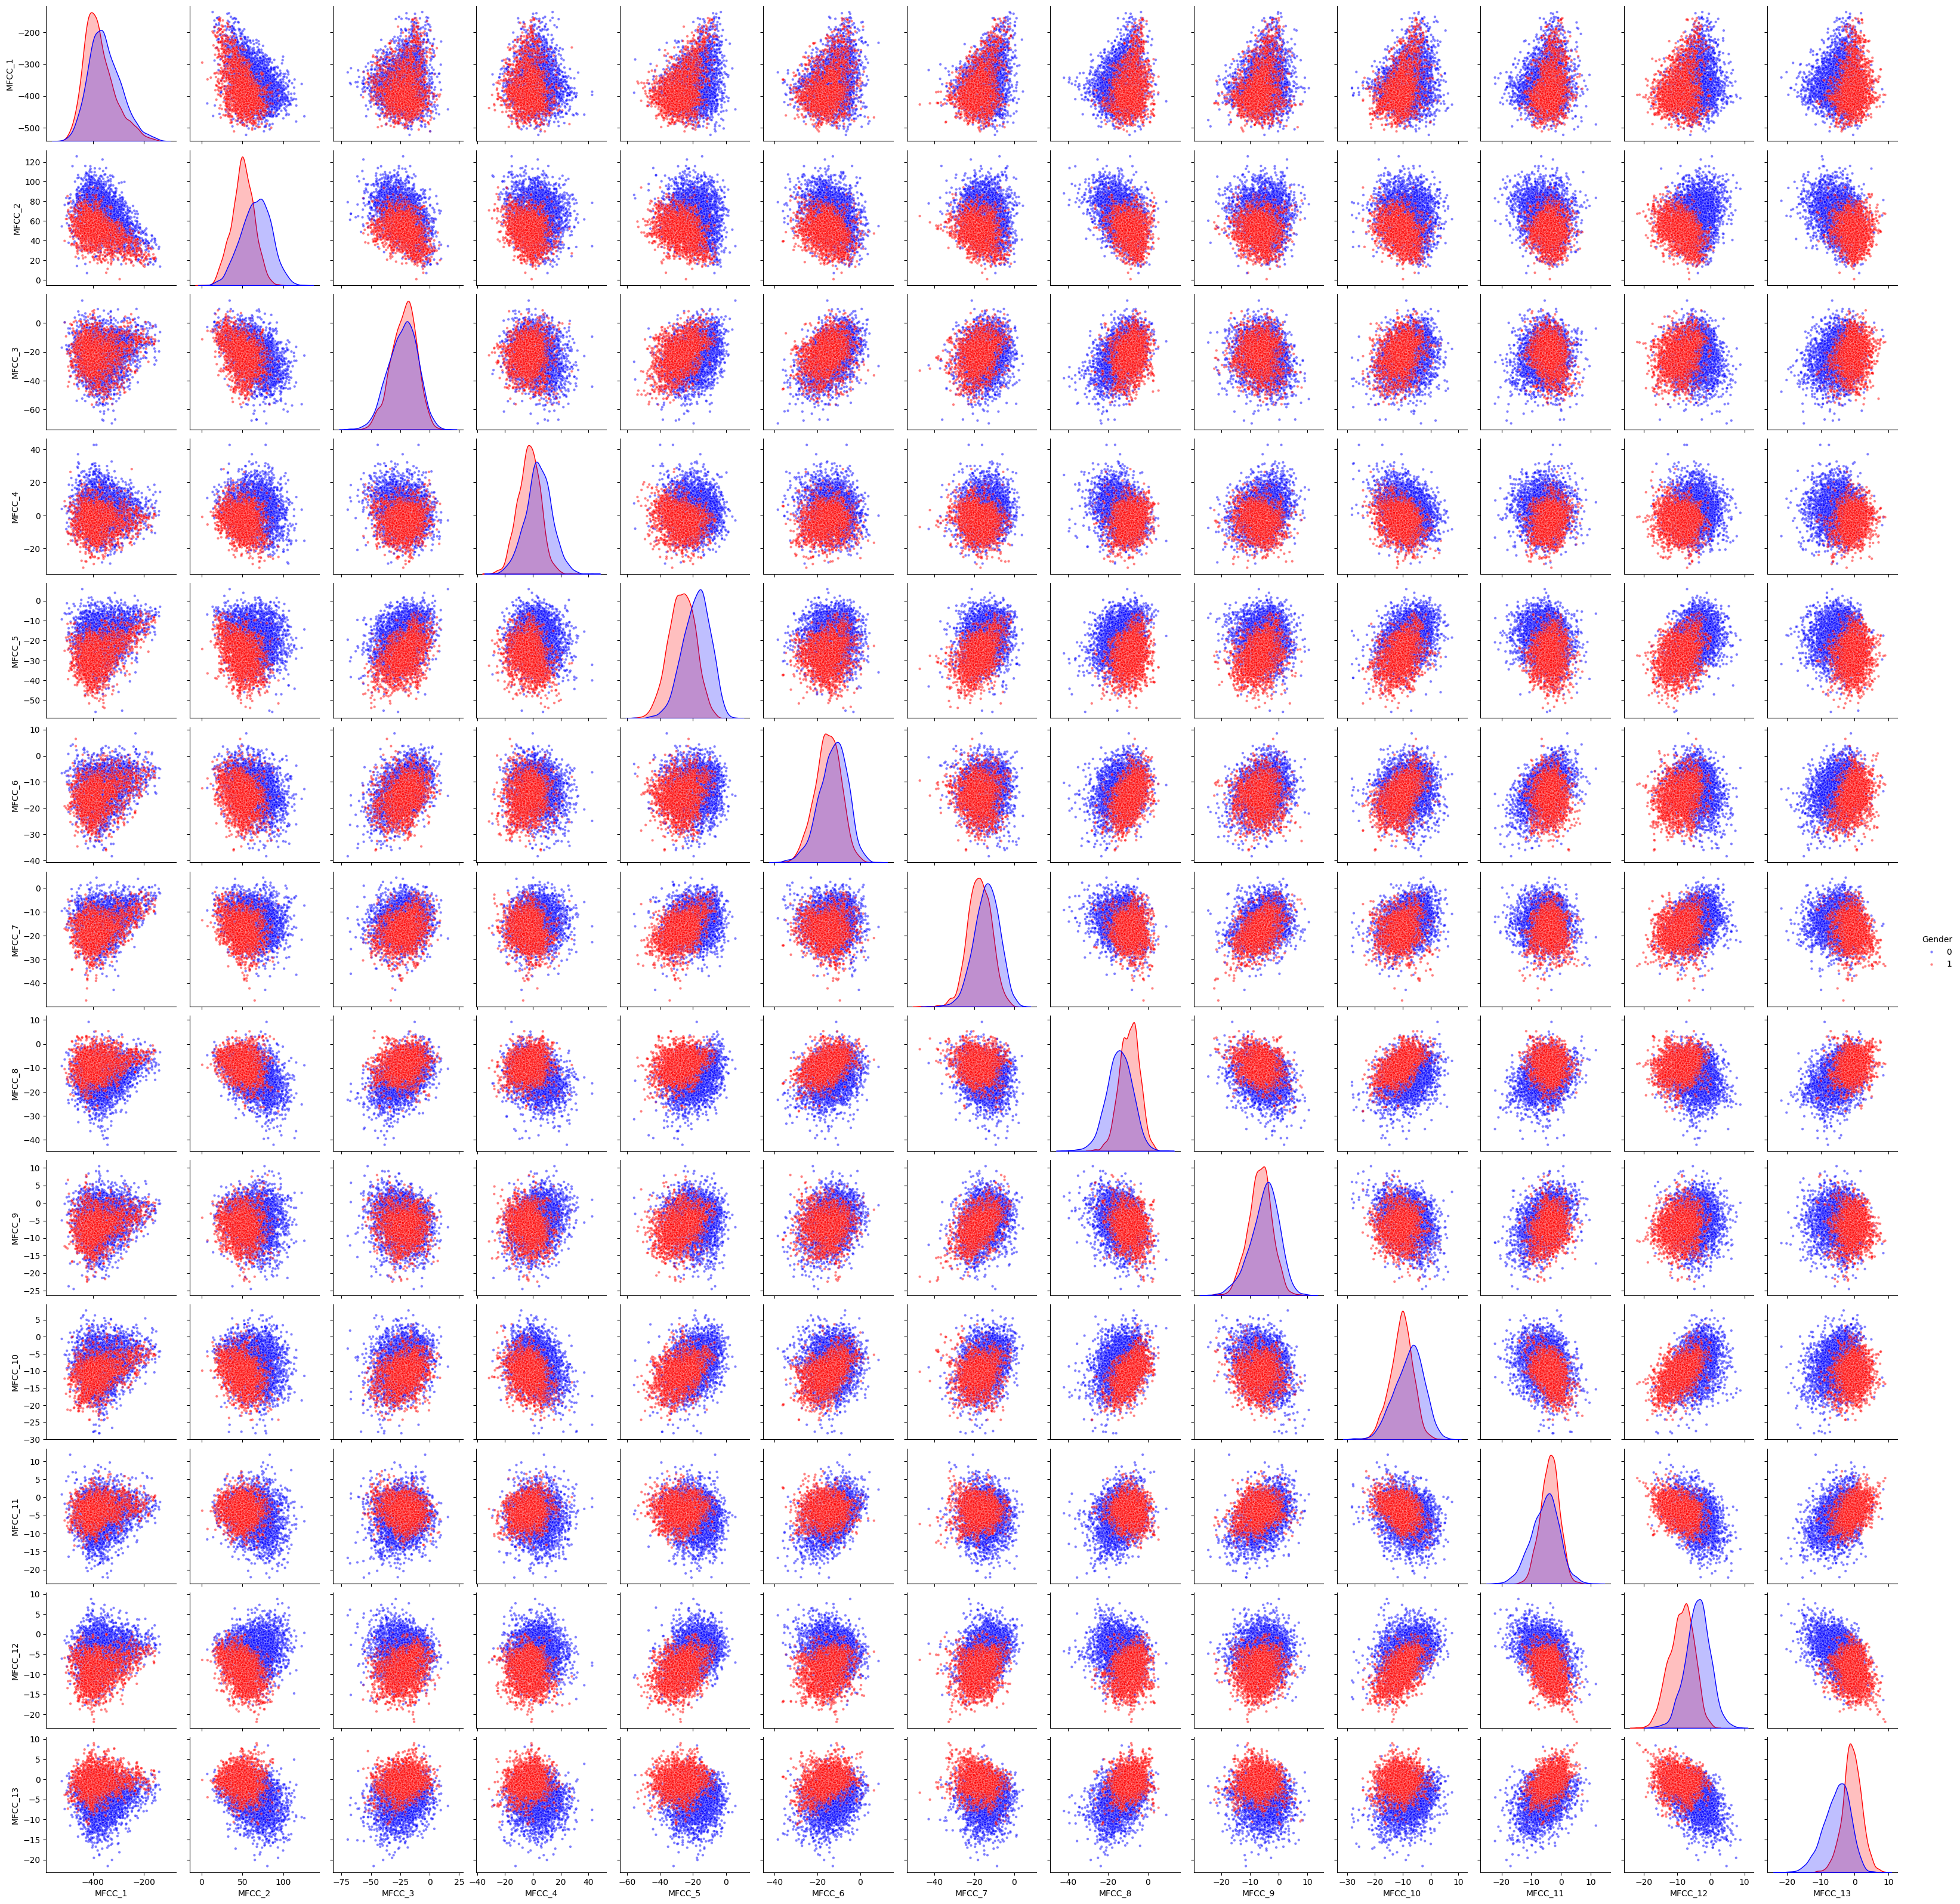

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce shape (5542, 13, 100) -> (5542, 13) by averaging over time frames
mfcc_mean = X_train_resampled.mean(axis=2).squeeze()  # Shape: (5542, 13)

# Convert to DataFrame
df = pd.DataFrame(mfcc_mean, columns=[f'MFCC_{i+1}' for i in range(mfcc_mean.shape[1])])

# Add gender labels
df['Gender'] = y_train_resampled.argmax(axis=1)  # Convert one-hot to class labels

# Pair plot
sns.pairplot(df, hue='Gender', palette=['blue', 'red'], diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})
plt.show()

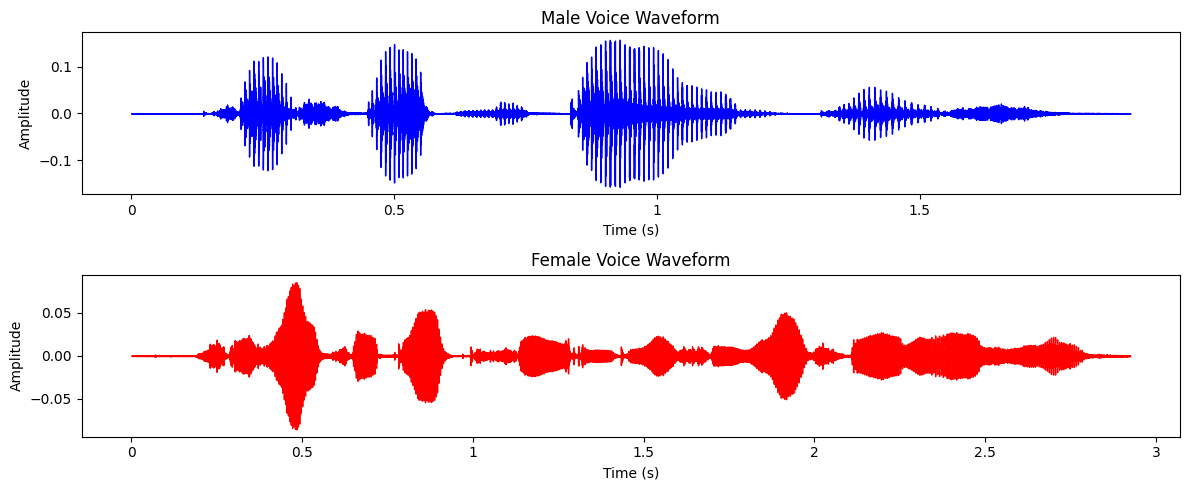

In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load a sample male and female audio file
male_audio_path = "data\TRAIN\DR1\MKLW0\SI2201.WAV"
female_audio_path = 'data/train/DR1/FCJF0/SA1.WAV'  

# Load waveforms
male_waveform, sr_male = librosa.load(male_audio_path, sr=None)
female_waveform, sr_female = librosa.load(female_audio_path, sr=None)

# Plot waveforms
plt.figure(figsize=(12, 5))

# Male waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(male_waveform, sr=sr_male, color='blue')
plt.title("Male Voice Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Female waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(female_waveform, sr=sr_female, color='red')
plt.title("Female Voice Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

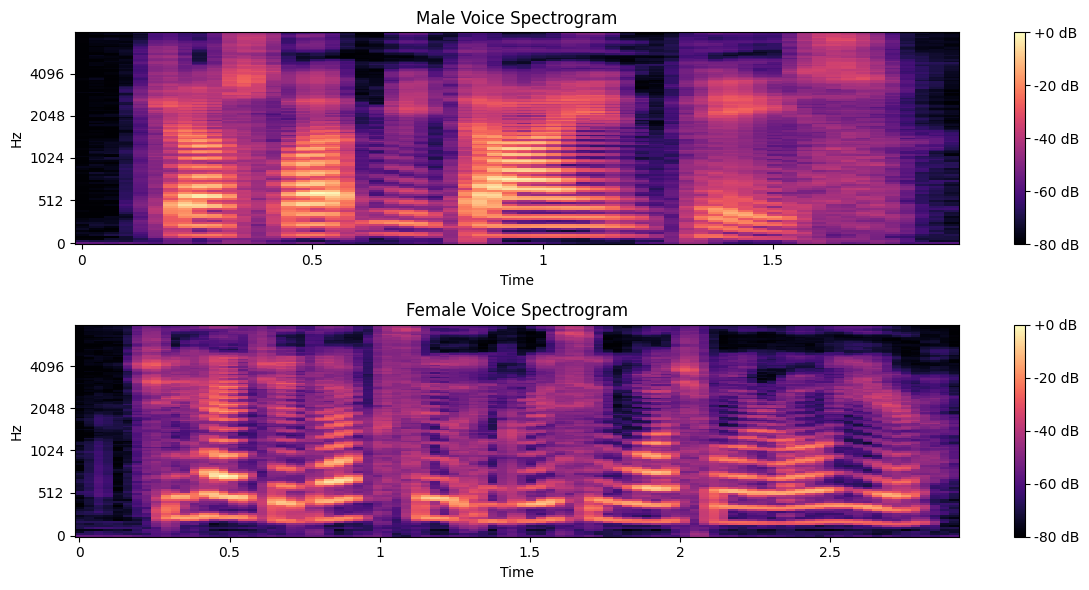

In [36]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Paths to male and female audio files (update with actual paths)
male_audio_path = "data\TRAIN\DR1\MKLW0\SI2201.WAV" 
female_audio_path = 'data/train/DR1/FCJF0/SA1.WAV'  

# Load waveforms
male_waveform, sr_male = librosa.load(male_audio_path, sr=None)
female_waveform, sr_female = librosa.load(female_audio_path, sr=None)

# Compute spectrograms
male_spectrogram = librosa.feature.melspectrogram(y=male_waveform, sr=sr_male, n_mels=128, fmax=8000)
female_spectrogram = librosa.feature.melspectrogram(y=female_waveform, sr=sr_female, n_mels=128, fmax=8000)

# Convert to log scale
male_db = librosa.power_to_db(male_spectrogram, ref=np.max)
female_db = librosa.power_to_db(female_spectrogram, ref=np.max)

# Plot spectrograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(male_db, sr=sr_male, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Male Voice Spectrogram")

plt.subplot(2, 1, 2)
librosa.display.specshow(female_db, sr=sr_female, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Female Voice Spectrogram")

plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


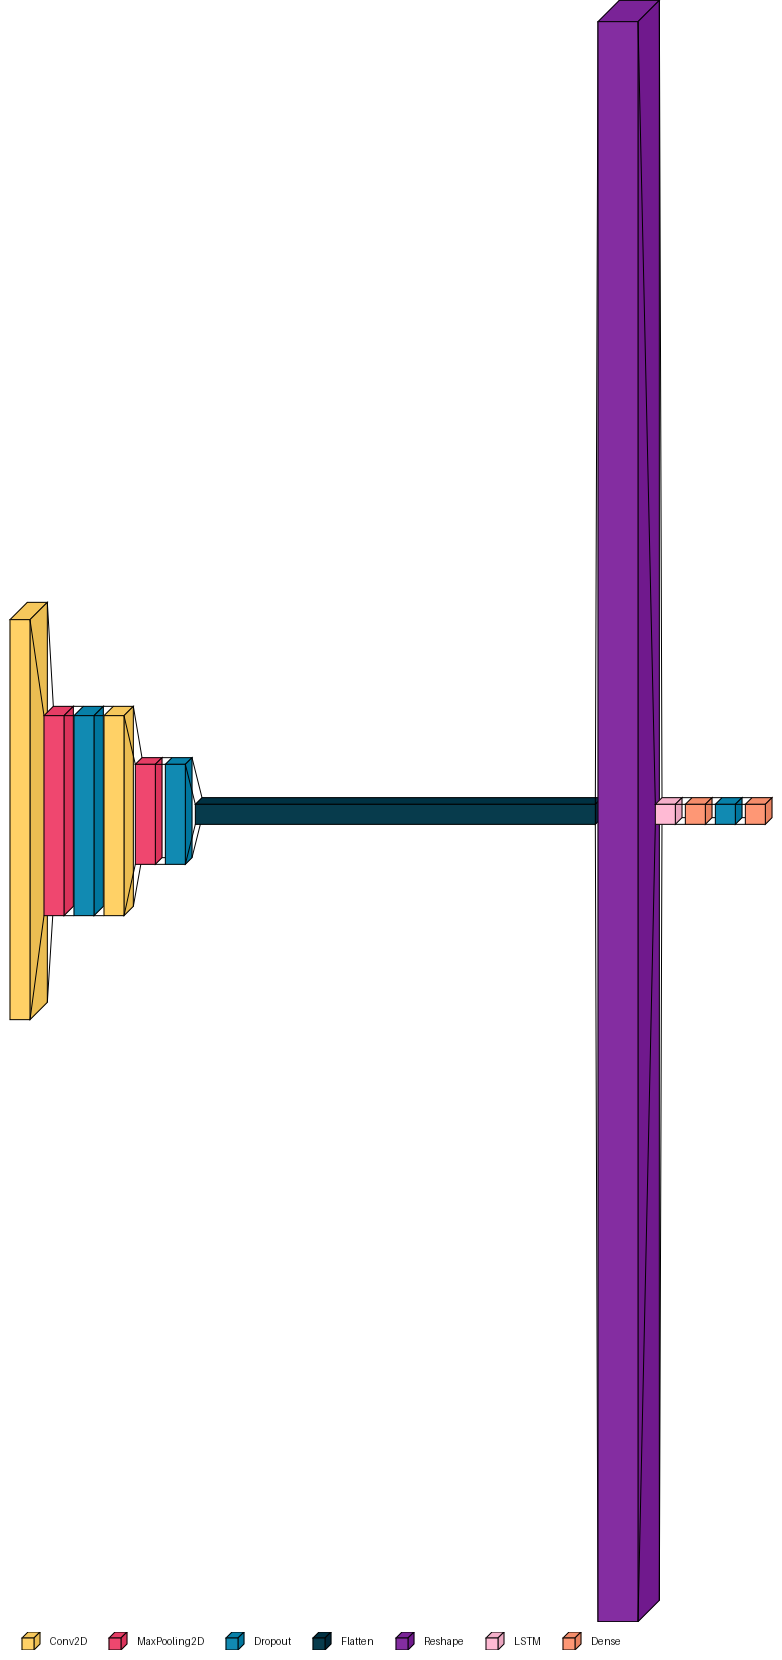

In [37]:
import visualkeras
from PIL import Image
from IPython.display import Image as IPImage, display

# Create the model visualization
image = visualkeras.layered_view(model, legend=True)

# Save the image temporarily to the output directory
image_path = 'model_visualization.png'
image.save(image_path)

# Display the image in the notebook output
display(IPImage(image_path))

In [38]:
from tensorflow.keras import layers, models
import tensorflow as tf

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(13, 100, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model with CategoricalCrossentropy
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Print the model summary to check the output shape of each layer
model.summary()

# Setup TensorBoard callback
log_dir = "/content/logs"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the TensorBoard callback
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

# Visualize the model architecture using TensorBoard
%load_ext tensorboard
%tensorboard --logdir /content/logs

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 11, 98, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 5, 49, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 5, 49, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 3, 47, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 1, 23, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 1, 23, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         188,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,618 (811.01 KB)

 Trainable params: 207,618 (811.01 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'TensorBoard' is not defined

In [39]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already defined as 'model'
plot_model(model, to_file='model_visualiz.png', show_shapes=True, show_layer_names=True)

# Display the model architecture directly in the notebook
from IPython.display import Image
Image(filename='model_visualiz.png')


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_visualiz.png'

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


ModuleNotFoundError: No module named 'keras.utils.vis_utils'